In [1]:
import sys
from pathlib import Path
from subprocess import Popen

import numpy as np
import matplotlib.pyplot as plt
import cv2
import open3d as o3d

import torch
import torchvision as tv
import torchvision.transforms.functional as tfunc
import torchvision.models as tvm
import torchvision.utils as vutils

sys.path.append('../')
import MalmoPython

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
MISSION_PORT = 9001
MISSION_FILE = Path("../random_world.xml")
VIDEO_SHAPE = (512, 512)
VIDEO_DEPTH = 4

In [3]:
def launch_malmo_client(mission_port):
    MALMO_ARGS = [f"/home/boggsj/Coding/Malmo-prebuilt/Minecraft/launchClient.sh", "-port", str(mission_port)]
    malmo_proc = Popen(MALMO_ARGS, stdout=sys.stdout)

In [4]:
launch_malmo_client(MISSION_PORT)

In [5]:
malmo_agent_host = MalmoPython.AgentHost()

malmo_client_info = MalmoPython.ClientInfo('127.0.0.1', MISSION_PORT)
malmo_client_pool = MalmoPython.ClientPool()
malmo_client_pool.add(malmo_client_info)

All the above code is the basic initialization code for Malmo. Useful as a reference, but not research

In [ ]:
MISSION_FILE = Path("../mobchase.xml")
pig_mission_spec = MalmoPython.MissionSpec(MISSION_FILE.read_text(), True)
pig_mission_record_spec = MalmoPython.MissionRecordSpec()
malmo_agent_host.startMission(pig_mission_spec, malmo_client_pool, pig_mission_record_spec, 0, "TEST ALPHA")

In [ ]:
state = malmo_agent_host.getWorldState()
state_image = np.frombuffer(state.video_frames[0].pixels, dtype=np.uint8)
state_image = state_image.reshape(VIDEO_SHAPE+(VIDEO_DEPTH,))
print(state_image.shape)
plt.figure()
plt.imshow(state_image)
plt.show()
plt.close()

The above code gets and shows a new image from the Minecraft agent every loop. 

**Note espectially**: The state image's pixels are given as a 1d bytearray, and must be converted to a numpy ndarray by decoding (as `uint8` AKA `unsigned char`) and then reshaped as `columns` x `rows` x `depth`

The next step is to load up the pig-following task and attempt to make the agent move.

In [ ]:
malmo_agent_host.sendCommand("turn 0")

In [ ]:
malmo_agent_host.sendCommand("quit")

In [ ]:
true = True
false = False
for i in range(10):
    world_state = malmo_agent_host.getWorldState()
    if world_state.number_of_observations_since_last_state < 1:
        continue
    o = next(iter(world_state.observations))
    obs_dict = eval(o.text)
    agent_x = obs_dict['XPos']
    agent_z = obs_dict['ZPos']
    found_pig = False
    for entity in obs_dict['entities']:
        if entity['name'] == 'Pig':
            pig_x = entity['x']
            pig_z = entity['z']
            dist = ((agent_x-pig_x)**2 + (agent_z-pig_z)**2)**0.5
            print(pig_x, pig_z, dist)
            found_pig = True

The above will load up the pig chasing mission, allow for sending commands, and demonstrates how the `ObservationFromNearbyEntities` schema works. 

I've learned a couple of things from playing around trying to get the above to work:
- There's no direct way to get reward from merely being near a mob. There is a `RewardForCatchingMob` signal available, but that requires actually cornering the mob so it can't escape.
- There's no direct observation signal provided for whether you're looking *near* a kind of mob (or any other entity). You can learn what entity is directly in the center of your vision, but not anything in the periphery
- There's no way to explicitly limit the `ObservationFromNearbyEntities` signal to the area which is in the agent's vision, such limiting would need to be done manually
- The `ObservationFromNearbyEntities` signal needs to be processed in order to find the entities of interest, there's no way to search faster than scanning through all returned entities.

Now there's a variety of directions I can go:
- Binary classifier is-pig-in-vision
- Prediction of next frame given current frame and next action
- Pig following agent using a pig-identifying network
- Learn body parts of a pig

In [ ]:
resnet50 = tvm.resnet50(weights=tvm.ResNet50_Weights.DEFAULT)

In [6]:
def get_malmo_image(world_state):
    state_image = np.frombuffer(world_state.video_frames[0].pixels, dtype=np.uint8)
    state_image = state_image.reshape(VIDEO_SHAPE+(VIDEO_DEPTH,))
    return state_image

In [ ]:
world_state = malmo_agent_host.getWorldState()
plt.imshow(get_malmo_image(world_state))
plt.show()
plt.close()

In [ ]:
rgbd_image = get_malmo_image(world_state)
rgb_image = rgbd_image[:,:,:3]
print(rgb_image.shape)
rgb_img_tensor = tfunc.to_tensor(rgb_image).reshape((1, 3) + rgb_image.shape[:2])
rgbd_img_tensor = tfunc.to_tensor(rgbd_image).reshape((1, 4) + rgbd_image.shape[:2])
print(rgb_img_tensor.shape)

In [217]:
from collections import OrderedDict
import torch
import torch.nn as nn

class ResNet_FPN(nn.Module):
    def __init__(self, arch, fpn_feat):
        super().__init__()
        self.resnet = getattr(tvm, arch)()
        self.fpn = tv.ops.FeaturePyramidNetwork(
            in_channels_list=[256, 512, 1024, 2048], out_channels=fpn_feat
        )
        self.feat_extender = nn.Sequential(
            nn.ConvTranspose2d(fpn_feat, fpn_feat, 4, 2, 1),
            nn.ConvTranspose2d(fpn_feat, fpn_feat, 4, 2, 1)
        )
        
        self.out_channels = fpn_feat

    def forward(self, x, with_dense=False):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        feat0 = self.resnet.layer1(x)
        feat1 = self.resnet.layer2(feat0)
        feat2 = self.resnet.layer3(feat1)
        feat3 = self.resnet.layer4(feat2)

        feats = OrderedDict()
        feats["0"] = feat0
        feats["1"] = feat1
        feats["2"] = feat2
        feats["3"] = feat3

        all_feats = self.fpn(feats)
        out_feats = self.feat_extender(all_feats["0"])
        return out_feats

fpn = ResNet_FPN("resnet50", 64).to(device)

In [ ]:
fpn_out = fpn(rgb_img_tensor)
# fpn_out_0 = fpn_out["0"]
# print(fpn_out_0.shape)
print(fpn_out.shape)

In [8]:
def draw_image(image, fname=None):
    if isinstance(image, torch.Tensor):
        if str(image.device) == 'cuda:0':
            image = image.detach().cpu()
        image = image.squeeze().numpy()
    plt.figure(figsize=(8,8))
    plt.axis("off")
    if len(image.shape) == 2:
        plt.imshow(image, interpolation="none", cmap="binary")
    else:
        if image.shape[2] not in [3, 4]:
            image = np.transpose(image, (1,2,0))
        plt.imshow(image, interpolation="none")
    plt.show()

    if fname:
        plt.savefig(fname)
    plt.close()
    
def draw_layers(data, fname=None):
    if isinstance(data, torch.Tensor):
        if str(data.device) == 'cuda:0':
            data = data.detach().cpu()
        data = data.squeeze().numpy()
    if len(data.shape) == 2:
        return draw_image(data)
    data_layers = [tfunc.to_tensor(d) for d in data]
    grid_image = vutils.make_grid(data_layers, nrow=int(len(data_layers)**0.5), padding=0, pad_value=0.5, normalize=True).cpu()
    draw_image(grid_image, fname)

In [ ]:
draw_layers(fpn_out.detach())

Clearly this will work about as smoothly as I'd hoped. The question now is what to do with it. I think the next step is to write the code to turn the RGB-D into an RGBXYZ point cloud akin to the Soar code I wrote. ~~Or to write a Soar interface of some kind, but that sounds frustrating and fruitless. I need an up.~~ With that point cloud, I have perfect registration of pixels across multiple images. Then I can maybe try and train a network to make consistent vectors of the same XYZ point regardless of the particulars of the RGB data it's getting

In [10]:
FOV_v = 70
FOV_h = FOV_v
H, W = VIDEO_SHAPE
P_delta = torch.Tensor([[((r/H)*FOV_v)-(FOV_v/2) for c in range(W)] for r in range(H)])
Y_delta = torch.Tensor([[((c/W)*FOV_h)-(FOV_h/2) for c in range(W)] for r in range(H)])

In [11]:
def get_xyz_coords(image, position, heading):
    pos_x, pos_y, pos_z = position
    pitch, yaw = heading
    P_adj = (P_delta + pitch)*(3.14159/180)
    Y_adj = (Y_delta + yaw)*(3.14159/180)
    V_x = -torch.sin(Y_adj) * torch.cos(P_adj)
    V_y = -torch.sin(P_adj)
    V_z = torch.cos(Y_adj) * torch.cos(P_adj)
    V = torch.concat([V_x.expand(1,512,512), V_y.expand(1,512,512), V_z.expand(1,512,512)])
    D = image[:,3,:,:]
    D_adj = D*V
    I = D_adj+torch.Tensor(position).reshape(1,3,1,1)
    return I
    

Note: Some input files use or override a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
1 warning
Note: Some input files use or override a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
1 warning


In [ ]:
true = True
false = False

o = next(iter(ws.observations))
obs_dict = eval(o.text)

agent_x = obs_dict['XPos']
agent_y = obs_dict['XPos']
agent_z = obs_dict['ZPos']

agent_yaw = obs_dict['Yaw']
agent_pitch = obs_dict['Pitch']

In [ ]:
points = get_xyz_coords(rgbd_img_tensor, (agent_x, agent_y, agent_z), (agent_pitch, agent_yaw))

points_np = np.transpose(points.numpy().squeeze(), (1,2,0)).astype(np.float64).reshape((512*512,3))
points_3d = o3d.utility.Vector3dVector(points_np)
point_cloud = o3d.geometry.PointCloud(points_3d)
point_cloud.colors = o3d.utility.Vector3dVector(rgb_image.reshape((512*512, 3))/256)
o3d.visualization.draw_geometries([point_cloud])
down_sampled_point_cloud = point_cloud.voxel_down_sample(0.01)

rgbxyz_tensor = torch.concat([rgb_img_tensor, points])

So what I'm thinking about now is how to use the fact that we have more-or-less trivial registration between two images for reward signal. Seems to me that the most straight-forward way is to try and get the predicted features of the prediction network to match the features of the target network on a per-point basis.


In [ ]:
fpn_feats = 64
prediction_f = ResNet_FPN("resnet50", fpn_feats)
prediction_g = nn.Sequential(
    nn.Linear(fpn_feats, fpn_feats),
    nn.ReLU(),
    nn.Linear(fpn_feats, fpn_feats),
    nn.ReLU()
)
prediction_q = nn.Sequential(
    nn.Linear(fpn_feats, fpn_feats),
    nn.ReLU(),
    nn.Linear(fpn_feats, fpn_feats),
    nn.ReLU()
)

target_f = ResNet_FPN("resnet50", fpn_feats)
target_g = nn.Sequential(
    nn.Linear(fpn_feats, fpn_feats),
    nn.ReLU(),
    nn.Linear(fpn_feats, fpn_feats),
    nn.ReLU()
)

In [ ]:
world_state = malmo_agent_host.getWorldState()
rgbd_image = get_malmo_image(world_state)
rgb_image_a = rgbd_image[:,:,:3]
rgb_img_tensor_a = tfunc.to_tensor(rgb_image_a).reshape((1, 3) + rgb_image_a.shape[:2])
rgbd_img_tensor_a = tfunc.to_tensor(rgbd_image).reshape((1, 4) + rgbd_image.shape[:2])

o = next(iter(world_state.observations))
obs_dict = eval(o.text)

agent_x_a = obs_dict['XPos']
agent_y_a = obs_dict['XPos']
agent_z_a = obs_dict['ZPos']

agent_yaw_a = obs_dict['Yaw']
agent_pitch_a = obs_dict['Pitch']

In [ ]:
world_state = malmo_agent_host.getWorldState()
rgbd_image = get_malmo_image(world_state)
rgb_image_b = rgbd_image[:,:,:3]
rgb_img_tensor_b = tfunc.to_tensor(rgb_image_b).reshape((1, 3) + rgb_image_b.shape[:2])
rgbd_img_tensor_b = tfunc.to_tensor(rgbd_image).reshape((1, 4) + rgbd_image.shape[:2])

o = next(iter(world_state.observations))
obs_dict = eval(o.text)

agent_x_b = obs_dict['XPos']
agent_y_b = obs_dict['XPos']
agent_z_b = obs_dict['ZPos']

agent_yaw_b = obs_dict['Yaw']
agent_pitch_b = obs_dict['Pitch']

In [ ]:
draw_image(rgb_img_tensor_a)
print(f"pos: ({agent_x_a}, {agent_y_a}, {agent_z_a}), heading: ({agent_pitch_a}, {agent_yaw_a})")

In [ ]:
draw_image(rgb_img_tensor_b)
print(f"pos: ({agent_x_b}, {agent_y_b}, {agent_z_b}), heading: ({agent_pitch_b}, {agent_yaw_b})")

In [ ]:
points_a = get_xyz_coords(rgbd_img_tensor_a, (agent_x_a, agent_y_a, agent_z_a), (agent_pitch_a, agent_yaw_a))

points_a_np = np.transpose(points_a.numpy().squeeze(), (1,2,0)).astype(np.float64).reshape((512*512,3))
points_a_3d = o3d.utility.Vector3dVector(points_a_np)
point_cloud_a = o3d.geometry.PointCloud(points_a_3d)
point_cloud_a.colors = o3d.utility.Vector3dVector(rgb_image_a.reshape((512*512, 3))/256)
o3d.visualization.draw_geometries([point_cloud_a])

rgbxyz_tensor_a = torch.concat([rgb_img_tensor_a, points_a])

In [ ]:
points_b = get_xyz_coords(rgbd_img_tensor_b, (agent_x_b, agent_y_b, agent_z_b), (agent_pitch_b, agent_yaw_b))

points_b_np = np.transpose(points_b.numpy().squeeze(), (1,2,0)).astype(np.float64).reshape((512*512,3))
points_b_3d = o3d.utility.Vector3dVector(points_b_np)
point_cloud_b = o3d.geometry.PointCloud(points_b_3d)
point_cloud_b.colors = o3d.utility.Vector3dVector(rgb_image_b.reshape((512*512, 3))/256)
o3d.visualization.draw_geometries([point_cloud_b])

rgbxyz_tensor_b = torch.concat([rgb_img_tensor_b, points_b])

In [ ]:
y_xi = target_f(rgb_img_tensor_a)
z_xi = target_g(y_xi.transpose(1,3)).detach()

y_theta = prediction_f(rgb_img_tensor_b)
z_theta = prediction_g(y_theta.transpose(1,3))
p_theta = prediction_q(z_theta)

In [ ]:
draw_image(points_a)
draw_image(points_b)

In [ ]:
dists = point_cloud_a.compute_point_cloud_distance(point_cloud_b)
dists = np.asarray(dists)
ind = np.where(dists < 0.01)[0]
point_cloud_reg = point_cloud_a.select_by_index(ind)
o3d.visualization.draw_geometries([point_cloud_a.paint_uniform_color([1.0,0.2, 0.2]), point_cloud_b.paint_uniform_color([0.2,0.2, 1.0])])
o3d.visualization.draw_geometries([point_cloud_reg])

The section below is for calibrating the camera intrinsic matrix so I can *accurately* recover the pixel coordinates.

In [34]:
MISSION_FILE = Path("../chessboard.xml")
pig_mission_spec = MalmoPython.MissionSpec(MISSION_FILE.read_text(), True)
pig_mission_record_spec = MalmoPython.MissionRecordSpec()
malmo_agent_host.startMission(pig_mission_spec, malmo_client_pool, pig_mission_record_spec, 0, "TEST ALPHA")

In [ ]:
import time

images = dict()
for x, z, yaw in [(-9, -9, 0), (-9, -9, -45), (-9, -9, -90),
                 (-9, 9, -90), (-9, 9, -135), (-9, 9, -180),
                 (9, 9, -180), (9, 9, -225), (9, 9, -270),
                 (9, -9, -270), (9, -9, -315), (9, -9, -360)]:
    for pitch in [-30, -20, -10, 0, 10, 20, 30]:
        malmo_agent_host.sendCommand(f"tp {x} 4 {z}")
        malmo_agent_host.sendCommand(f"setPitch {pitch}")
        malmo_agent_host.sendCommand(f"setYaw {yaw}")
        time.sleep(1)
        ws = malmo_agent_host.getWorldState()
        images[(x,z,yaw,pitch)] = get_malmo_image(ws)

In [33]:
malmo_agent_host.sendCommand("quit")

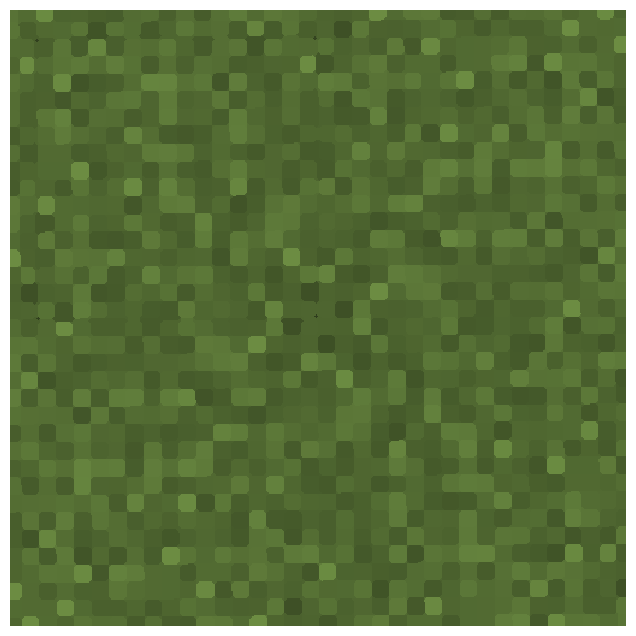

False


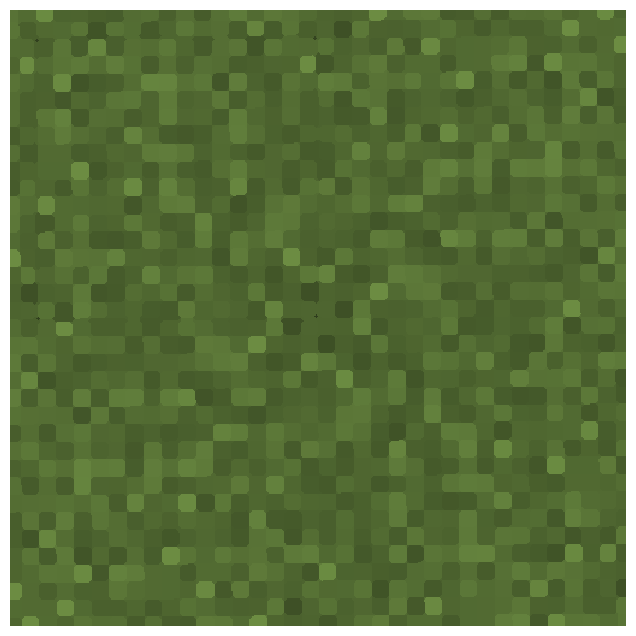

In [67]:
ws = malmo_agent_host.getWorldState()
chessboard_img_d = get_malmo_image(ws)
chessboard_img = chessboard_img_d[:,:,:3]
chessboard_img = cv2.medianBlur(chessboard_img, 5)
draw_image(chessboard_img)

CORNERS = (3,4)
retval, corners = cv2.findChessboardCorners(chessboard_img, CORNERS)
print(retval)

ret = False
gray_chessboard = cv2.cvtColor(chessboard_img, cv2.COLOR_BGR2GRAY)
corners_img = cv2.drawChessboardCorners(chessboard_img, CORNERS, corners, ret)
draw_image(corners_img)

In [68]:
true = True
false = False
ws = malmo_agent_host.getWorldState()
o = next(iter(ws.observations))
obs_dict = eval(o.text)

In [69]:
obs_dict

{'LineOfSight': {'hitType': 'block',
  'x': 0.0,
  'y': 4.0,
  'z': 0.0,
  'type': 'grass',
  'prop_snowy': False,
  'inRange': True,
  'distance': 1.6200000047683716},
 'DistanceTravelled': 0,
 'TimeAlive': 8969,
 'MobsKilled': 0,
 'PlayersKilled': 0,
 'DamageTaken': 0,
 'DamageDealt': 0,
 'Life': 20.0,
 'Score': 0,
 'Food': 20,
 'XP': 0,
 'IsAlive': True,
 'Air': 300,
 'Name': 'Agent0',
 'XPos': 0.0,
 'YPos': 4.0,
 'ZPos': 0.0,
 'Pitch': 90.0,
 'Yaw': 0.29993922,
 'WorldTime': 8972,
 'TotalTime': 8972}

In [55]:
objp = np.zeros((1, CORNERS[0] * CORNERS[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CORNERS[0], 0:CORNERS[1]].T.reshape(-1, 2)
h,w = chessboard_img.shape[:2]

retval, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera([objp], [corners], (h,w), None, None)

In [60]:
objp

array([[[0., 0., 0.],
        [1., 0., 0.],
        [2., 0., 0.],
        [0., 1., 0.],
        [1., 1., 0.],
        [2., 1., 0.],
        [0., 2., 0.],
        [1., 2., 0.],
        [2., 2., 0.],
        [0., 3., 0.],
        [1., 3., 0.],
        [2., 3., 0.]]], dtype=float32)

In [56]:
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(cameraMatrix, distCoeffs, (w,h), 1, (w,h))

In [57]:
newcameramtx

array([[260.49227905,   0.        , 279.22332236],
       [  0.        , 262.74996948, 262.38951318],
       [  0.        ,   0.        ,   1.        ]])

In [58]:
dst = cv2.undistort(chessboard_img_d, cameraMatrix, distCoeffs, None, newcameramtx)

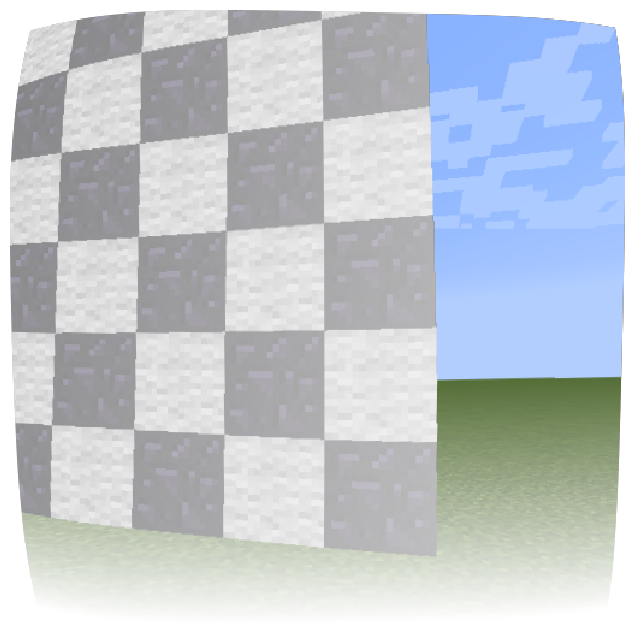

In [59]:
draw_image(dst)

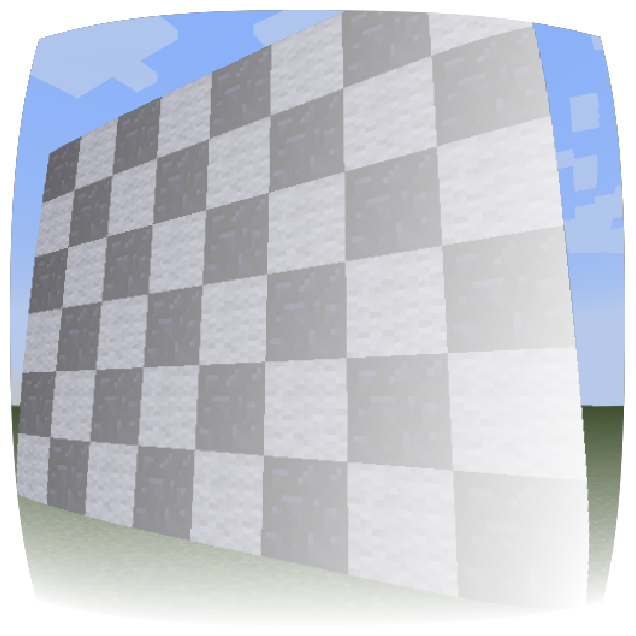

In [46]:
mapx,mapy=cv2.initUndistortRectifyMap(cameraMatrix,distCoeffs,None,newcameramtx,(w,h),5)
 
dst = cv2.remap(chessboard_img_d,mapx,mapy,cv2.INTER_LINEAR)
draw_image(dst)

/tmp/ipykernel_18842/1653831897.py:19: RuntimeWarning: invalid value encountered in divide
  rgbd_rescaled = (rgbd_image/[1,1,1,scale_factor])


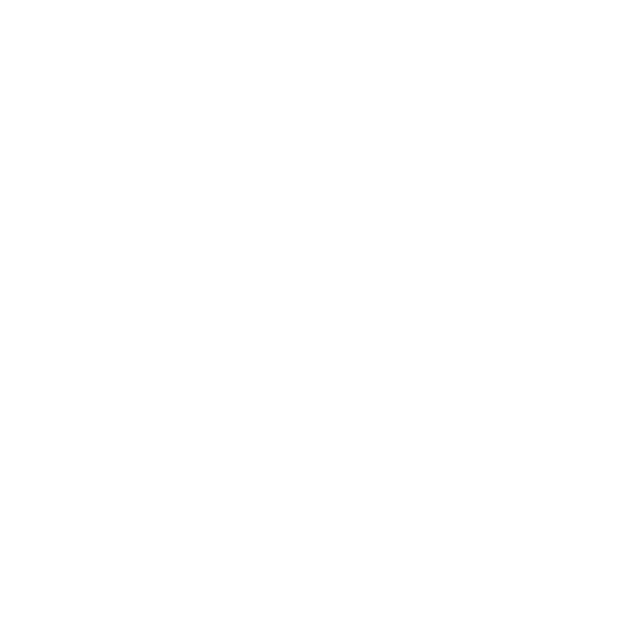

1.6200000047683716 0 nan 0.0


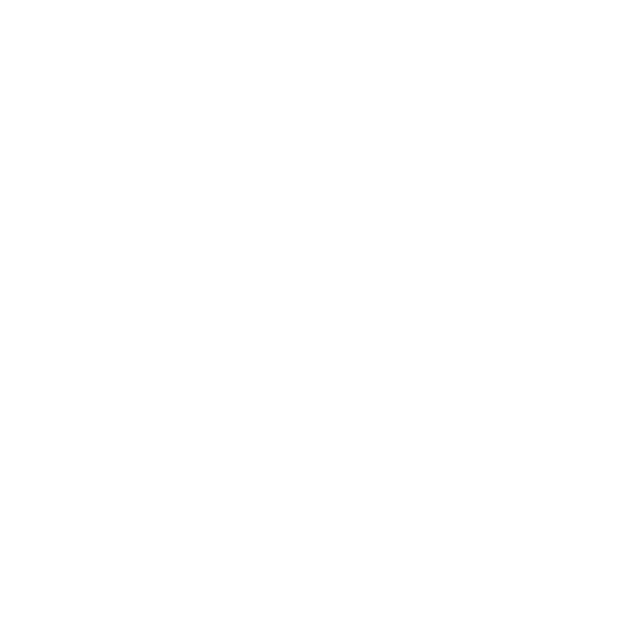

1.6200000047683716 0 nan 0.0


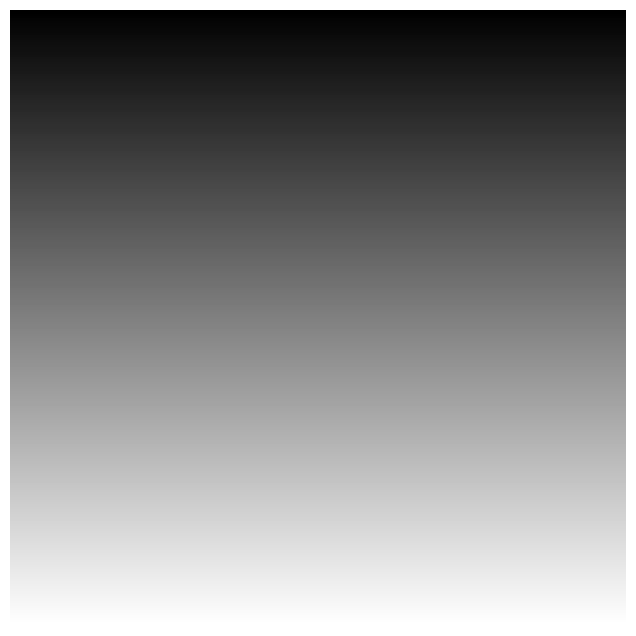

1.6449795961380005 127 1.6449795961380005 77.20460502863631


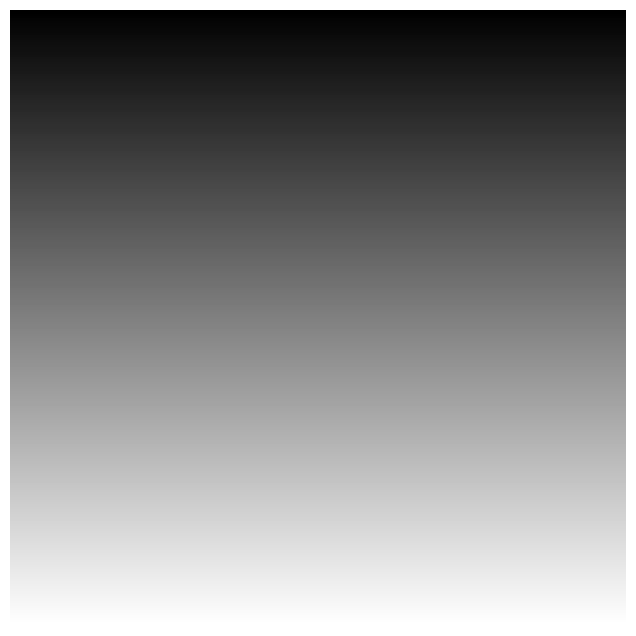

1.723921537399292 127 1.723921537399292 73.6692461024602


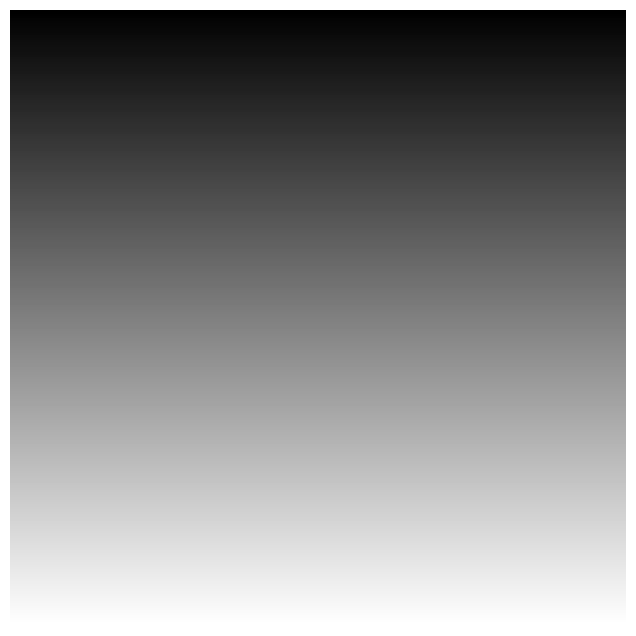

1.723921537399292 127 1.723921537399292 73.6692461024602


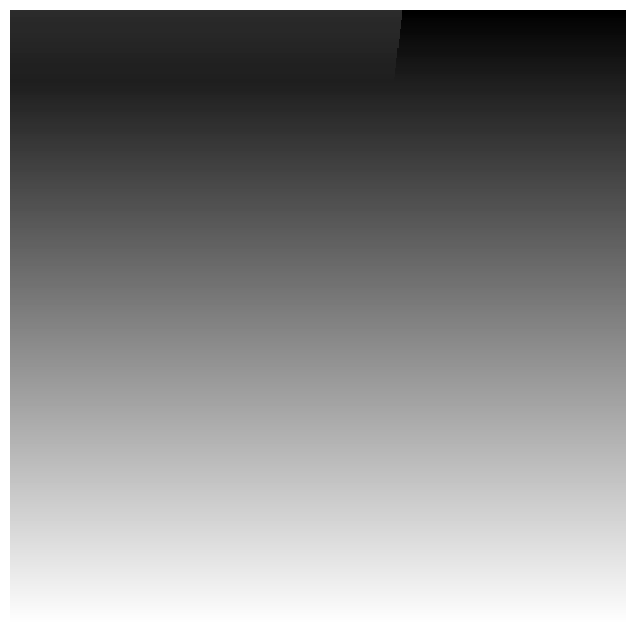

2.1146976947784424 127 2.1146976947784424 60.05586534358323


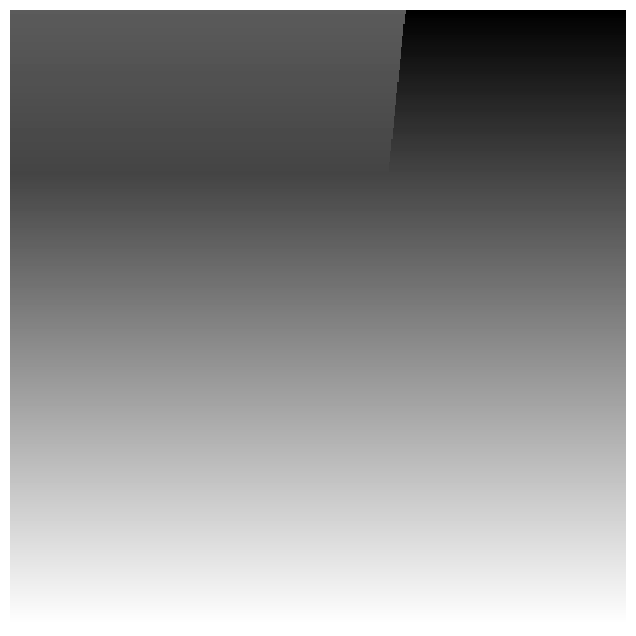

2.5203776359558105 127 2.5203776359558105 50.389274285016974


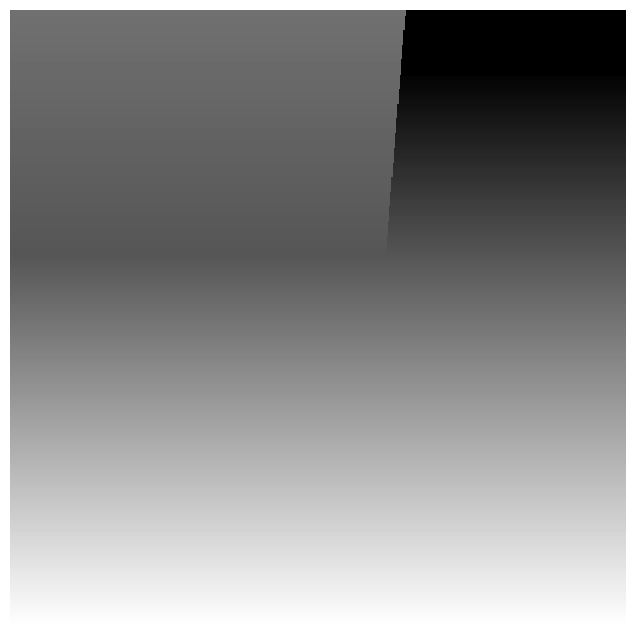

3.2400448322296143 140 3.2400448322296143 43.209278651758645


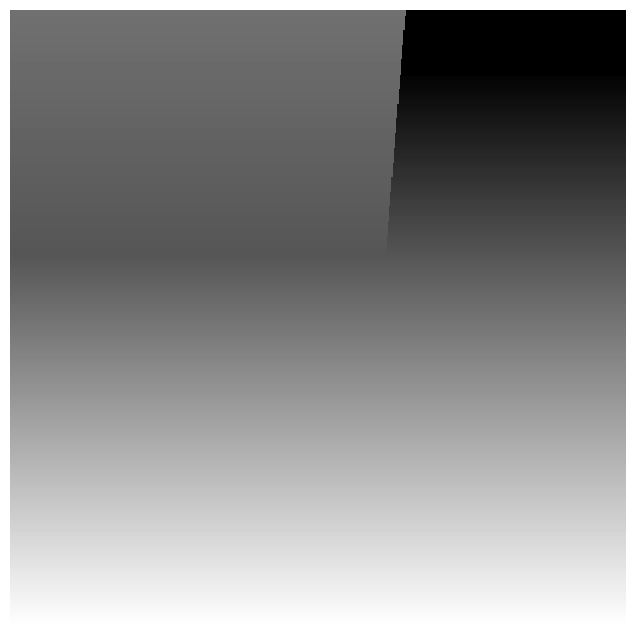

3.2400448322296143 140 3.2400448322296143 43.209278651758645


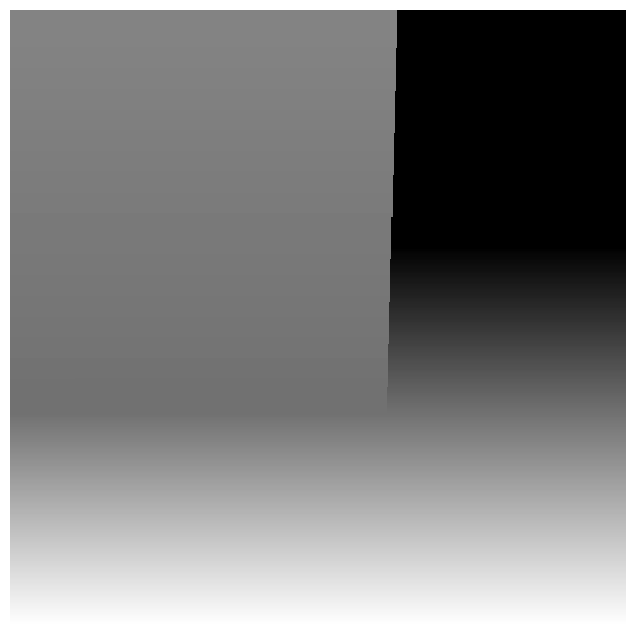

4.061677932739258 138 4.061677932739258 33.97610600477392


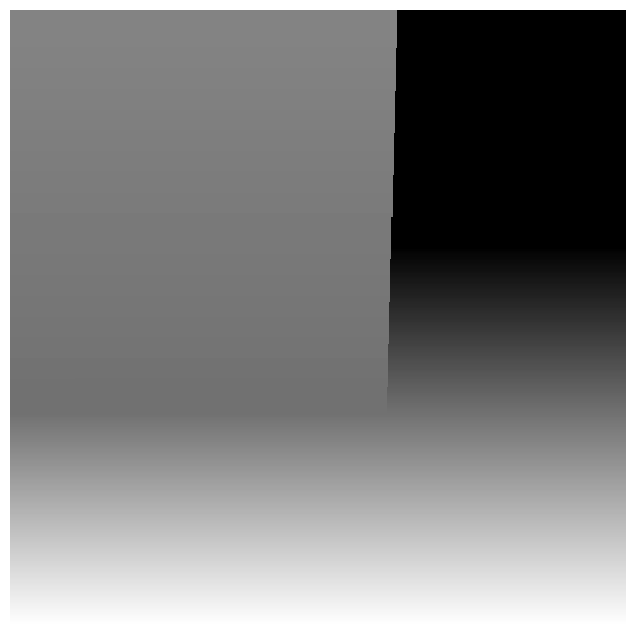

4.0 138 4.0 34.5


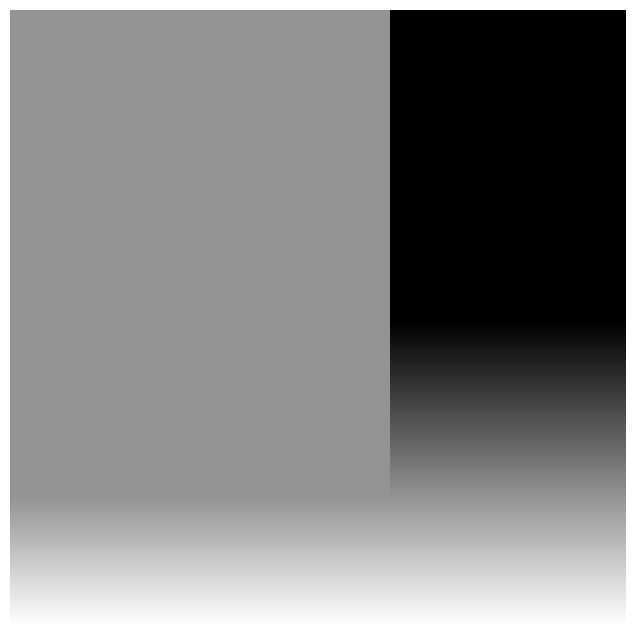

4.0 107 4.0 26.75


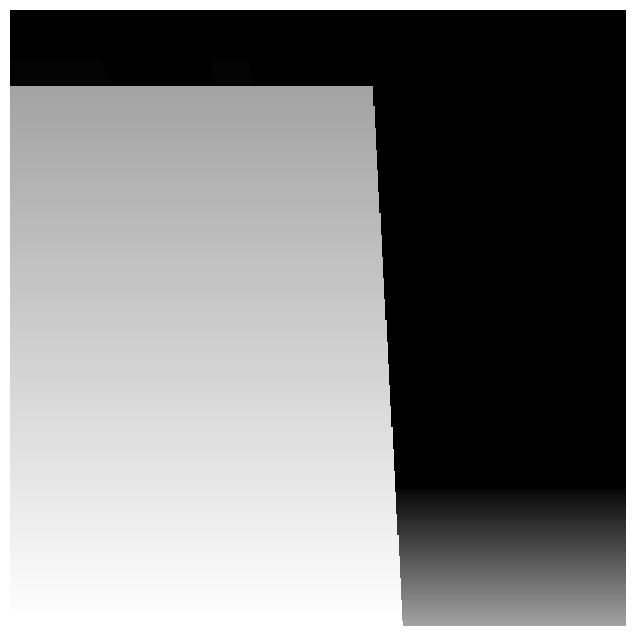

4.2565789222717285 52 4.2565789222717285 12.216383379600934


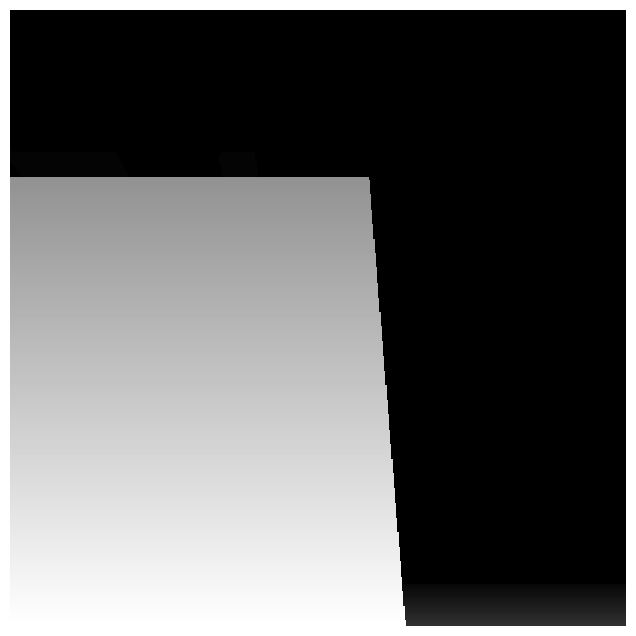

4.618716716766357 74 4.618716716766357 16.021766334222953


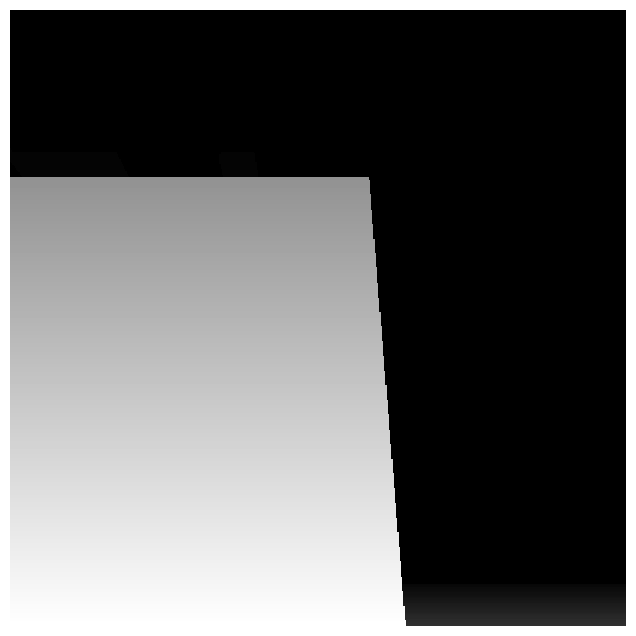

4.618716716766357 74 4.618716716766357 16.021766334222953


KeyError: 'LineOfSight'

In [99]:
malmo_agent_host.sendCommand(f"setPitch 90")
malmo_agent_host.sendCommand(f"setYaw 0")
for pitch in range(90, -90, -10):
    malmo_agent_host.sendCommand(f"setPitch {pitch}")
    ws = malmo_agent_host.getWorldState()
    rgbd_image = get_malmo_image(ws)
    # rgbd_image = cv2.remap(chessboard_img_d,mapx,mapy,cv2.INTER_LINEAR)
    # rgbd_image = cv2.undistort(rgbd_image, cameraMatrix, distCoeffs, None, newcameramtx)
    rgb_image = rgbd_image[:,:,:3]
    d_image = rgbd_image[:,:,3]
#     print(rgb_image.shape)
#     rgb_img_tensor = tfunc.to_tensor(rgb_image).reshape((1, 3) + rgb_image.shape[:2])
#     rgbd_img_tensor = tfunc.to_tensor(rgbd_image).reshape((1, 4) + rgbd_image.shape[:2])

    o = next(iter(ws.observations))
    obs_dict = eval(o.text)
    dist = obs_dict['LineOfSight']['distance'] 
    scale_factor = d_image[256,256]/dist
    rgbd_rescaled = (rgbd_image/[1,1,1,scale_factor])
    
#     draw_image(rgbd_image)
    draw_image(rgbd_rescaled[:,:,-1])
    print(dist, d_image[256,256], rgbd_rescaled[:,:,-1][256,256], scale_factor)
    

In [72]:
d_image

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

(512, 512, 3)


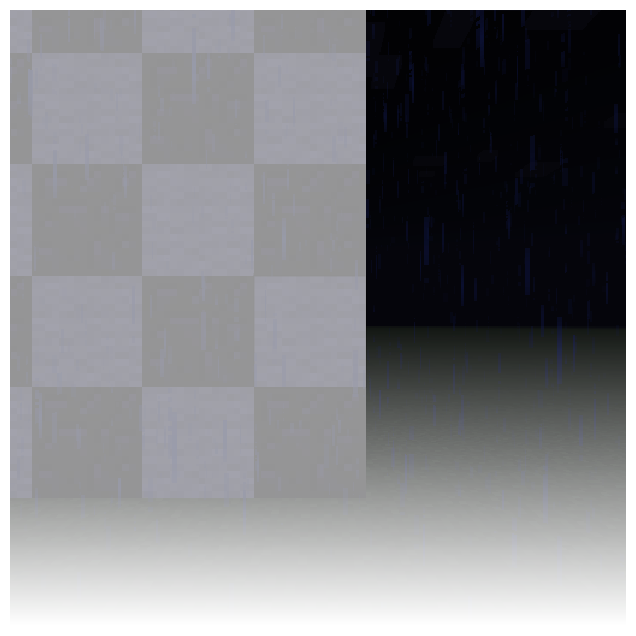

In [106]:
malmo_agent_host.sendCommand(f"setPitch 0")
malmo_agent_host.sendCommand(f"setYaw 0")
malmo_agent_host.sendCommand(f"tp 01 4 0")
ws = malmo_agent_host.getWorldState()
rgbd_image = get_malmo_image(ws)
# rgbd_image = cv2.remap(chessboard_img_d,mapx,mapy,cv2.INTER_LINEAR)
# rgbd_image = cv2.undistort(rgbd_image, cameraMatrix, distCoeffs, None, newcameramtx)
rgb_image = rgbd_image[:,:,:3]
d_image = rgbd_image[:,:,3]
print(rgb_image.shape)
rgb_img_tensor = tfunc.to_tensor(rgb_image).reshape((1, 3) + rgb_image.shape[:2])
rgbd_img_tensor = tfunc.to_tensor(rgbd_image).reshape((1, 4) + rgbd_image.shape[:2])
draw_image(rgbd_image)

In [107]:
o = next(iter(ws.observations))
obs_dict = eval(o.text)
dist = obs_dict['LineOfSight']['distance'] 
scale_factor = d_image[256,256]/dist
rgbd_rescaled = (rgbd_image/[1,1,1,scale_factor])

0 [255  86] 170
1 [255 170] 146
2 [255 256] 122
3 [178  97] 169
4 [175 174] 148
5 [175 257] 124
6 [107 106] 169
7 [104 182] 147
8 [100 259] 126
9 [ 44 116] 255
10 [ 39 187] 148
11 [ 35 262] 127


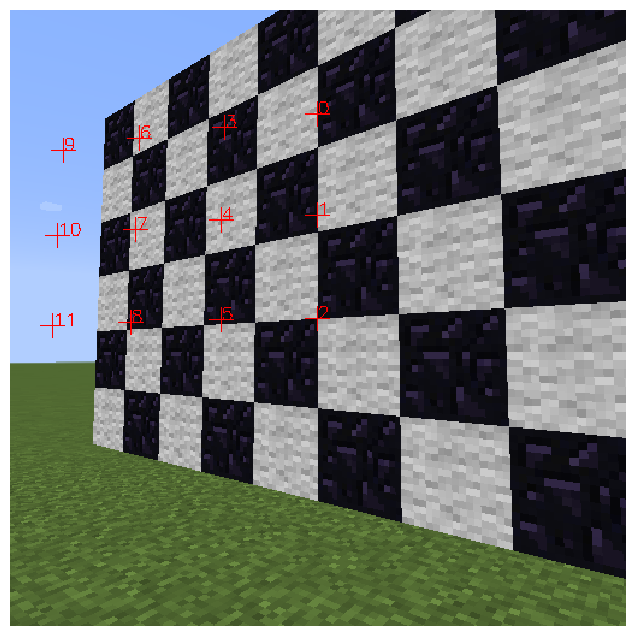

In [64]:
marked_image = rgb_image.copy()
for i, c in enumerate(corners.round().squeeze().astype(int)):
    cv2.drawMarker(marked_image, c, (255,0,0))
    cv2.putText(marked_image, str(i), c, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0))
    print(i, c, d_image[c[0], c[1]])
draw_image(marked_image)

In [123]:
points = get_xyz_coords(rgbd_img_tensor, (1, 4, 0), (0, 0))
points_np = np.transpose(points.numpy().squeeze(), (1,2,0)).astype(np.float64).reshape((512*512,3))
points_3d = o3d.utility.Vector3dVector(points_np)
point_cloud = o3d.geometry.PointCloud(points_3d)
point_cloud.colors = o3d.utility.Vector3dVector(rgb_image.reshape((512*512, 3))/256)
down_sampled_point_cloud = point_cloud.voxel_down_sample(0.01)

rgbxyz_tensor = torch.concat([rgb_img_tensor, points])

In [124]:
rgbd_rescaled_tensor = tfunc.to_tensor(rgbd_rescaled).reshape((1, 4) + rgbd_rescaled.shape[:2])
points = get_xyz_coords(rgbd_rescaled_tensor, (1, 4, 0), (0, 0))

points_np = np.transpose(points.numpy().squeeze(), (1,2,0)).astype(np.float64).reshape((512*512,3))
points_3d = o3d.utility.Vector3dVector(points_np)
point_cloud_r = o3d.geometry.PointCloud(points_3d)
point_cloud_r.colors = o3d.utility.Vector3dVector(rgb_image.reshape((512*512, 3))/256)
down_sampled_point_cloud = point_cloud.voxel_down_sample(0.01)

rgbxyz_r_tensor = torch.concat([rgb_img_tensor, points])

In [ ]:
o3d_rgb_image = o3d.geometry.Image(rgb_image)
o3d_d_image = o3d.geometry.Image(rgbd_image)
o3d_rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(o3d_rgb_image, o3d_d_image)
point_cloud = o3d.geometry.PointCloud.create_from_rgbd_image(o3d_rgbd_image, cameraMatrix)

In [ ]:
o3d_rgb_image

In [ ]:
o3d_d_image

In [ ]:
o3d_rgbd_image

Just playing around with composing easily obtained image features here

In [158]:
ws = malmo_agent_host.getWorldState()
rgbd_image = get_malmo_image(ws)
rgb_image = rgbd_image[:,:,:3]
d_image = rgbd_image[:,:,3]

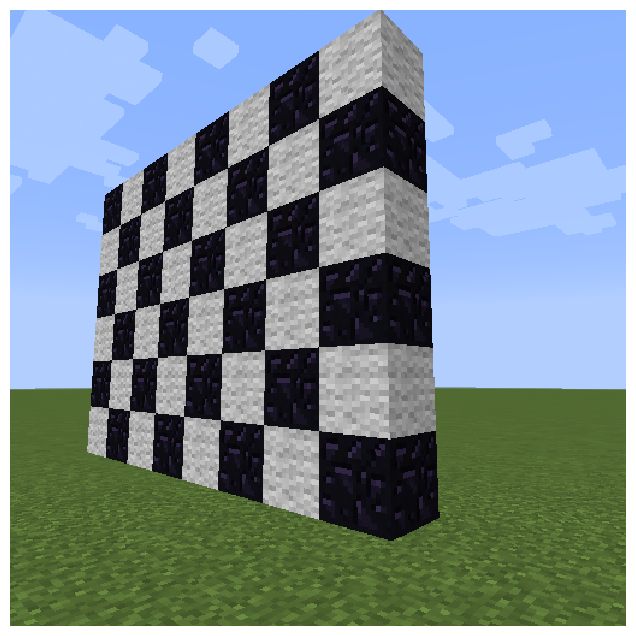

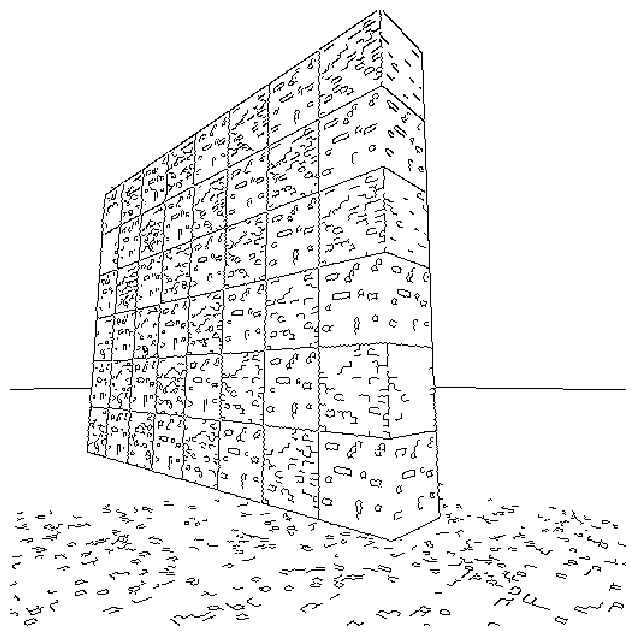

In [167]:
blurred_image = cv2.medianBlur(rgb_image, 1)
edge_image = cv2.Canny(blurred_image, 200.0, 100.0)
draw_image(blurred_image)
draw_image(edge_image)

In [177]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
faster_rcnn = tvm.detection.fasterrcnn_resnet50_fpn_v2(weights = tvm.detection.FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT).to(device).eval()

In [183]:
rgb_img_tensor = tfunc.to_tensor(rgb_image).reshape((1, 3) + rgb_image.shape[:2]).to(device)
rgbd_img_tensor = tfunc.to_tensor(rgbd_image).reshape((1, 4) + rgbd_image.shape[:2]).to(device)

In [186]:
output = faster_rcnn(rgb_img_tensor)

In [201]:
output[0]['boxes'][0].detach().cpu().numpy()

array([255.52763, 350.59323, 357.48117, 440.2929 ], dtype=float32)

In [205]:
cv2.rectangle(rgb_img_tensor, output[0]['boxes'][0].detach().cpu().numpy())

error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - rectangle() missing required argument 'pt2' (pos 3)
>  - rectangle() missing required argument 'pt2' (pos 3)
>  - rectangle() missing required argument 'color' (pos 3)
>  - rectangle() missing required argument 'color' (pos 3)


In [218]:
fpn_out = fpn(rgb_img_tensor)

AttributeError: 'collections.OrderedDict' object has no attribute 'shape'